# **Sentiment Classification using Transformers**

In [1]:
!pip install -q transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.31.0 which is incompatible.


In [2]:
!pip -q install portalocker
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q torchtext==0.15.2
!pip install -q torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.7/848.7 MB 1.2 MB/s eta 0:00:00
ERROR: pip's dependency resolv

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import SST2
from torchtext.vocab import build_vocab_from_iterator
from transformers import BertTokenizer
from torch.nn.functional import one_hot
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

 **Loading the dataset and printing samples**

In [6]:
train_iter = SST2(split='train')
test_iter = SST2(split='dev') #Using validation set as the test set as the test set has no labels

print("Sample training examples:")
for i, (text, label) in enumerate(train_iter):
    print(f"Text: {text}")
    print(f"Label: {label}")
    if i == 2:
        break

Sample training examples:
Text: hide new secretions from the parental units
Label: 0
Text: contains no wit , only labored gags
Label: 0
Text: that loves its characters and communicates something rather beautiful about human nature
Label: 1


In [7]:
print("Test set samples:")
for i, sample in enumerate(test_iter):
    print(f"Sample {i}: {sample}")
    if i == 2:
        break

Test set samples:
Sample 0: ("it 's a charming and often affecting journey .", 1)
Sample 1: ('unflinchingly bleak and desperate', 0)
Sample 2: ('allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker .', 1)


**Preprocessing**

In [8]:
train_iter = SST2(split='train')
test_iter = SST2(split='dev')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #Using bert tokenizer

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = tokenizer.tokenize(text)
    # Remove stopwords and punctuation
    tokens = [t for t in tokens if t not in stop_words and t not in punctuation]
    return tokens

train_data = [(preprocess(text), int(label)) for text, label in train_iter]
test_data = [(preprocess(text), int(label)) for text, label in test_iter]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
#Printing tokens
for i in range(3):
    print(f"Sample {i}: {train_data[i]}")

Sample 0: (['hide', 'new', 'secret', '##ions', 'parental', 'units'], 0)
Sample 1: (['contains', 'wit', 'labor', '##ed', 'gag', '##s'], 0)
Sample 2: (['loves', 'characters', 'communicate', '##s', 'something', 'rather', 'beautiful', 'human', 'nature'], 1)


**Converting to numerical tokens**

In [10]:
def yield_tokens(data_iter):
    for tokens, _ in data_iter:
        yield tokens

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

#Converting into numerical data using torchtext.vocab
train_numerical = [(vocab(tokens), label) for tokens, label in train_data]
test_numerical = [(vocab(tokens),label) for tokens, label in test_data]

for i in range(3):
    print(f"Sample {i}: {train_numerical[i]}")

label_count=Counter([label for _, label in train_numerical])
for label, count in label_count.items():
    print(f"Label {label}: {count} samples")

Sample 0: ([4373, 36, 2404, 5528, 7618, 8835], 0)
Sample 1: ([3746, 164, 1508, 22, 554, 2], 0)
Sample 2: ([2396, 15, 4903, 2, 43, 136, 222, 102, 378], 1)
Label 0: 29780 samples
Label 1: 37569 samples


**One Hot Encoding**

In [11]:
def one_hot_labels(label, num_classes=2):
    return one_hot(torch.tensor(label), num_classes=num_classes)

train_oh = [(torch.tensor(tokens), one_hot_labels(label)) for tokens, label in train_numerical]
test_oh = [(torch.tensor(tokens),one_hot_labels(label)) for tokens, label in test_numerical]

print("Final processed samples:")
for tokens, label in train_oh[:3]:
    print(f"Token IDs: {tokens}")
    print(f"One-hot Label: {label}")
    print("\n")

Final processed samples:
Token IDs: tensor([4373,   36, 2404, 5528, 7618, 8835])
One-hot Label: tensor([1, 0])


Token IDs: tensor([3746,  164, 1508,   22,  554,    2])
One-hot Label: tensor([1, 0])


Token IDs: tensor([2396,   15, 4903,    2,   43,  136,  222,  102,  378])
One-hot Label: tensor([0, 1])




**Splitting into train and validation sets, Class distribution**

In [12]:
import random
random.seed(42)
random.shuffle(train_numerical)

train_length=int(0.8*len(train_numerical))
val_length=len(train_numerical)-train_length
print('Train data size: '+str(train_length))
print('Validation data size: '+str(val_length))

training_data=train_numerical[:train_length]
validation_data=train_numerical[train_length:train_length+val_length]
testing_data=test_numerical

print("\nTraining data class distribution")
label_count=Counter([label for _, label in training_data])
for label, count in label_count.items():
    print(f"Label {label}: {count} samples")

print("\nTesting data class distribution")
label_count=Counter([label for _, label in testing_data])
for label, count in label_count.items():
    print(f"Label {label}: {count} samples")

Train data size: 53879
Validation data size: 13470

Training data class distribution
Label 0: 23826 samples
Label 1: 30053 samples

Testing data class distribution
Label 1: 444 samples
Label 0: 428 samples


In [13]:
# Hyperparameters Given
d_model = 16
nhead = 4
num_layers = 1
dropout = 0.5
batch_size = 32
epochs = 5
lr = 1e-3
max_len = 5000
num_classes = 2
vocab_size=len(vocab)

**Encoder Layer**

In [14]:
class Custom_EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.5):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_model)
        self.dropout_ff = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_model, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # src: (seq_len, batch_size, d_model)
        attn_output, _ = self.self_attn(src, src, src)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        ff_output = self.linear2(self.dropout_ff(F.relu(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)

        return src

**Positional Encoding**

In [15]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, device=None):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(1).to(device)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return x

**Transformer Model**

In [16]:
class SentimentClassifier_1(nn.Module):
    def __init__(self, vocab_size, d_model=16, nhead=4, num_layers=1, num_classes=2, dropout=0.5, max_len=5000, device=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, device=device)
        self.dropout = nn.Dropout(dropout)

        self.encoder_layers = nn.ModuleList([
            Custom_EncoderLayer(d_model, nhead, dropout) for _ in range(num_layers)
        ])

        self.classifier = nn.Linear(d_model, num_classes) #Linear layer for classification

    def forward(self, src):
        # src: (batch_size, seq_len)
        src = self.embedding(src)  # (batch_size, seq_len, d_model)
        src = self.dropout(src)
        src = src.transpose(0, 1)  # (seq_len, batch_size, d_model)
        src = self.pos_encoder(src)

        for layer in self.encoder_layers:
            src = layer(src)

        output = src.mean(dim=0)
        logits = self.classifier(output)
        return logits

In [17]:
def train_model(model, train_loader, val_loader, device, epochs=5, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_losses.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    return train_losses, val_losses

In [18]:
def test_model(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    #EValuation Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )

    print(f"Test Accuracy:  {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall:    {recall:.4f}")
    print(f"Test F1 Score:  {f1:.4f}\n")


    print("Classification Report:")
    print(classification_report(
        all_labels, all_preds, target_names=class_names, zero_division=0
    ))

In [19]:
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    token_ids, labels = zip(*batch)
    token_ids = [torch.tensor(ids, dtype=torch.long) for ids in token_ids]
    token_ids_padded = pad_sequence(token_ids, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return token_ids_padded, labels

#Creating DataLoaders
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

**Training**

Epoch 1/5 [Train]: 100%|██████████| 1684/1684 [00:09<00:00, 174.81it/s]


Epoch 1: Train Acc = 0.5896, Val Acc = 0.6831


Epoch 2/5 [Train]: 100%|██████████| 1684/1684 [00:06<00:00, 246.92it/s]


Epoch 2: Train Acc = 0.6834, Val Acc = 0.7560


Epoch 3/5 [Train]: 100%|██████████| 1684/1684 [00:06<00:00, 257.74it/s]


Epoch 3: Train Acc = 0.7392, Val Acc = 0.7936


Epoch 4/5 [Train]: 100%|██████████| 1684/1684 [00:06<00:00, 241.81it/s]


Epoch 4: Train Acc = 0.7732, Val Acc = 0.8140


Epoch 5/5 [Train]: 100%|██████████| 1684/1684 [00:06<00:00, 259.99it/s]


Epoch 5: Train Acc = 0.7973, Val Acc = 0.8194


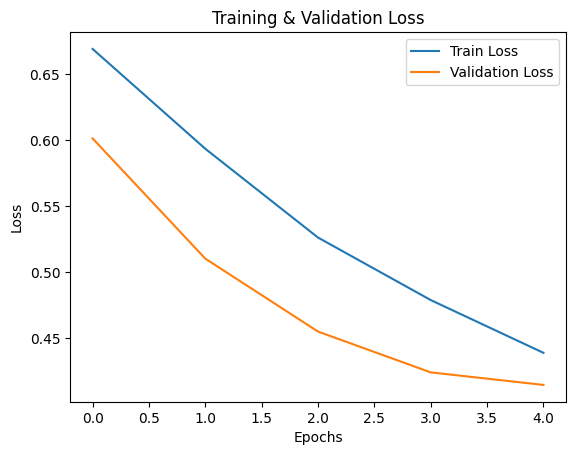

In [20]:
model_1 = SentimentClassifier_1(vocab_size, d_model, nhead, num_layers, num_classes, dropout, max_len, device=device).to(device)
train_losses_1, val_losses_1 = train_model(model_1, train_loader, val_loader, device, epochs, lr)

#Plotting loss curves
plt.plot(train_losses_1, label='Train Loss')
plt.plot(val_losses_1, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

**Testing**

In [21]:
test_model(model_1,test_loader, device)

Test Accuracy:  0.7557
Test Precision: 0.7681
Test Recall:    0.7557
Test F1 Score:  0.7522

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       428
           1       0.71      0.87      0.78       444

    accuracy                           0.76       872
   macro avg       0.77      0.75      0.75       872
weighted avg       0.77      0.76      0.75       872



**Model Summary**

In [22]:
from torchinfo import summary

dummy_input = torch.randint(0, vocab_size, (batch_size, d_model), dtype=torch.long).to(device)
summary(model_1, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
SentimentClassifier_1                    [32, 2]                   --
├─Embedding: 1-1                         [32, 16, 16]              182,704
├─Dropout: 1-2                           [32, 16, 16]              --
├─PositionalEncoding: 1-3                [16, 32, 16]              --
├─ModuleList: 1-4                        --                        --
│    └─Custom_EncoderLayer: 2-1          [16, 32, 16]              --
│    │    └─MultiheadAttention: 3-1      [16, 32, 16]              1,088
│    │    └─Dropout: 3-2                 [16, 32, 16]              --
│    │    └─LayerNorm: 3-3               [16, 32, 16]              32
│    │    └─Linear: 3-4                  [16, 32, 16]              272
│    │    └─Dropout: 3-5                 [16, 32, 16]              --
│    │    └─Linear: 3-6                  [16, 32, 16]              272
│    │    └─Dropout: 3-7                 [16, 32, 16]              --
│    

**Transformer model with nn.TransformerEncoderLayer**

In [23]:
class SentimentClassifier_2(nn.Module):
    def __init__(self, vocab_size, d_model=16, nhead=4, num_layers=1, num_classes=2, dropout=0.5, max_len=5000, device=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, device=device)
        self.dropout = nn.Dropout(dropout)

        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model,nhead,dim_feedforward=d_model,dropout=dropout) for _ in range(num_layers)
        ])

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, src):
        # src: (batch_size, seq_len)
        src = self.embedding(src)  # (batch_size, seq_len, d_model)
        src = self.dropout(src)
        src = src.transpose(0, 1)  # (seq_len, batch_size, d_model)
        src = self.pos_encoder(src)

        for layer in self.encoder_layers:
            src = layer(src)

        output = src.mean(dim=0)
        logits = self.classifier(output)
        return logits

**Training**

Epoch 1/5 [Train]: 100%|██████████| 1684/1684 [00:07<00:00, 237.41it/s]


Epoch 1: Train Acc = 0.5900, Val Acc = 0.6740


Epoch 2/5 [Train]: 100%|██████████| 1684/1684 [00:06<00:00, 248.00it/s]


Epoch 2: Train Acc = 0.6724, Val Acc = 0.7593


Epoch 3/5 [Train]: 100%|██████████| 1684/1684 [00:07<00:00, 231.22it/s]


Epoch 3: Train Acc = 0.7263, Val Acc = 0.7955


Epoch 4/5 [Train]: 100%|██████████| 1684/1684 [00:06<00:00, 246.58it/s]


Epoch 4: Train Acc = 0.7611, Val Acc = 0.8176


Epoch 5/5 [Train]: 100%|██████████| 1684/1684 [00:07<00:00, 219.98it/s]


Epoch 5: Train Acc = 0.7829, Val Acc = 0.8319


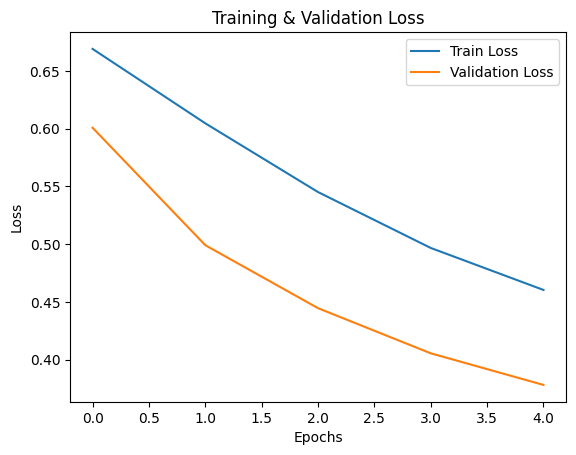

In [24]:
model_2 = SentimentClassifier_2(vocab_size, d_model, nhead, num_layers, num_classes, dropout, max_len, device=device).to(device)
train_losses_2, val_losses_2 = train_model(model_2, train_loader, val_loader, device, epochs, lr)

#Plotting Loss Curves
plt.plot(train_losses_2, label='Train Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

**Testing**

In [25]:
test_model(model_2,test_loader, device)

Test Accuracy:  0.7557
Test Precision: 0.7580
Test Recall:    0.7557
Test F1 Score:  0.7548

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       428
           1       0.74      0.81      0.77       444

    accuracy                           0.76       872
   macro avg       0.76      0.75      0.75       872
weighted avg       0.76      0.76      0.75       872



**Model Summary**

In [26]:
summary(model_2, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
SentimentClassifier_2                    [32, 2]                   --
├─Embedding: 1-1                         [32, 16, 16]              182,704
├─Dropout: 1-2                           [32, 16, 16]              --
├─PositionalEncoding: 1-3                [16, 32, 16]              --
├─ModuleList: 1-4                        --                        --
│    └─TransformerEncoderLayer: 2-1      [16, 32, 16]              --
│    │    └─MultiheadAttention: 3-1      [16, 32, 16]              1,088
│    │    └─Dropout: 3-2                 [16, 32, 16]              --
│    │    └─LayerNorm: 3-3               [16, 32, 16]              32
│    │    └─Linear: 3-4                  [16, 32, 16]              272
│    │    └─Dropout: 3-5                 [16, 32, 16]              --
│    │    └─Linear: 3-6                  [16, 32, 16]              272
│    │    └─Dropout: 3-7                 [16, 32, 16]              --
│    

**Transfer Learning with BERT**

In [ ]:
from sklearn.model_selection import train_test_split

train_iter = list(SST2(split='train'))
test_iter= list(SST2(split='dev'))

texts = [text for text, label in train_iter]
labels = [int(label) for text, label in train_iter]

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

test_texts = [text for text, label in test_iter]
test_labels = [int(label) for text, label in test_iter]

**Using BERT Tokenizer**

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 64

def encode(texts, tokenizer, max_len):
    encoded = tokenizer(texts, padding='max_length', truncation=True,
                        max_length=MAX_LEN, return_tensors='pt')
    return encoded['input_ids'], encoded['attention_mask']

train_input_ids, train_attention_masks = encode(train_texts, tokenizer, MAX_LEN)
val_input_ids, val_attention_masks = encode(val_texts, tokenizer, MAX_LEN)
test_input_ids, test_attention_masks = encode(test_texts, tokenizer, MAX_LEN)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
class SST2Dataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [ ]:
train_dataset = SST2Dataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = SST2Dataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = SST2Dataset(test_input_ids, test_attention_masks, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

**BERT Model**

In [ ]:
class BERTSentimentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False  # freeze BERT
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
model_3 = BERTSentimentClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.classifier.parameters(), lr=lr)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

**Training**

Epoch 1: Train Loss=0.5403, Acc=0.7330 | Val Loss=0.4561, Acc=0.8034


Epoch 2: Train Loss=0.4663, Acc=0.7853 | Val Loss=0.4158, Acc=0.8234


Epoch 3: Train Loss=0.4459, Acc=0.7960 | Val Loss=0.4050, Acc=0.8249


Epoch 4: Train Loss=0.4381, Acc=0.8027 | Val Loss=0.4038, Acc=0.8262


Epoch 5: Train Loss=0.4290, Acc=0.8070 | Val Loss=0.4235, Acc=0.8099


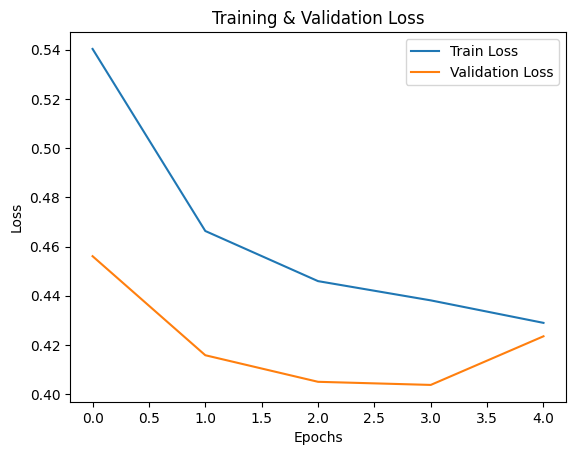

In [ ]:
train_losses_3, val_losses_3 = [], []
train_accuracies_3, val_accuracies_3 = [], []

for epoch in range(epochs):
    model_3.train()
    epoch_train_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model_3(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    train_loss = epoch_train_loss / len(train_loader)
    train_acc = correct / total
    train_losses_3.append(train_loss)
    train_accuracies_3.append(train_acc)

    # Validation
    model_3.eval()
    epoch_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model_3(input_ids, attention_mask)
            loss = criterion(logits, labels)
            epoch_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = epoch_val_loss / len(val_loader)
    val_acc = correct / total
    val_losses_3.append(val_loss)
    val_accuracies_3.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")


plt.plot(train_losses_3, label='Train Loss')
plt.plot(val_losses_3, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

**Testing**

In [ ]:
model_3.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model_3(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

print(f"Test Accuracy:  {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall:    {recall:.4f}")
print(f"Test F1 Score:  {f1:.4f}\n")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, zero_division=0))

Test Accuracy:  0.7489
Test Precision: 0.7927
Test Recall:    0.7489
Test F1 Score:  0.7378


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.54      0.68       428
           1       0.68      0.95      0.79       444

    accuracy                           0.75       872
   macro avg       0.79      0.75      0.74       872
weighted avg       0.79      0.75      0.74       872



**Model Summary**

In [ ]:
print(model_3)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [ ]:
print("Parameter training status:\n")
for name, param in model_3.named_parameters():
    print(f"{name:60s} | requires_grad = {param.requires_grad}")

Parameter training status:

bert.embeddings.word_embeddings.weight                       | requires_grad = False
bert.embeddings.position_embeddings.weight                   | requires_grad = False
bert.embeddings.token_type_embeddings.weight                 | requires_grad = False
bert.embeddings.LayerNorm.weight                             | requires_grad = False
bert.embeddings.LayerNorm.bias                               | requires_grad = False
bert.encoder.layer.0.attention.self.query.weight             | requires_grad = False
bert.encoder.layer.0.attention.self.query.bias               | requires_grad = False
bert.encoder.layer.0.attention.self.key.weight               | requires_grad = False
bert.encoder.layer.0.attention.self.key.bias                 | requires_grad = False
bert.encoder.layer.0.attention.self.value.weight             | requires_grad = False
bert.encoder.layer.0.attention.self.value.bias               | requires_grad = False
bert.encoder.layer.0.attention.output

* All 3 transformer models give comparable performance on the test dataset
*   Custom Encoder Model : 75.57%
*   Using nn.TransformerEncoderLayer : 75.57%
*   BERT : 74.89%
* The validation accuracy is much higher in BERT model